\pagebreak
\tableofcontents
\pagebreak

\scriptsize

In [316]:
'''Importing Packages'''
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import dates
from IPython.display import Markdown as md
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import datetime
from statsmodels.api import stats as sm
from loess import loess_1d
from statsmodels.graphics.tsaplots import plot_acf
from openpyxl import Workbook, load_workbook
from sklearn import linear_model
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.linalg import toeplitz
import math
import scipy.stats as stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
#import warnings
#from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
#warnings.simplefilter('ignore', ConvergenceWarning, ValueWarning)
%matplotlib inline

# (40 points) Table B.22 contains data from the Danish Energy Agency on Danish crude oil production.

In [317]:
'''importing the data and cleaning/formatting'''

data_1 = pd.read_excel('data.xlsx', sheet_name='B.22-CRUDEOIL', skiprows= 3)
data_1 = data_1.set_index(['Year'])
data_1_new_index = [(i,j) for i in data_1.index.tolist() for j in data_1.columns.tolist()]

data_1_clean = pd.DataFrame(index=pd.MultiIndex.from_tuples(data_1_new_index), columns=['Production'])

for i in data_1_new_index:
    data_1_clean.loc[i] = data_1.loc[i[0], i[1]]
data_1_clean = data_1_clean.reset_index()
data_1_clean_new_index = ['{}-0{}'.format(i,j) 
                        if j <10 else '{}-{}'.format(i,j)
                        for i in range(2001,2015) for j in range(1,13)
                        ]
data_1_clean['Date'] = data_1_clean_new_index
data_1_clean = data_1_clean.set_index('Date')
data_1_clean = data_1_clean.drop(['level_0', 'level_1'], axis = 1)
data_1_clean['Production'] = [
    i if i != '--' else np.NAN for i in data_1_clean['Production'].values
]
data_1_clean = data_1_clean.dropna()

\pagebreak

## Plot the data and comment on any features that you observe from the graph. Calculate and plot the sample ACF and variogram. Interpret these graphs.

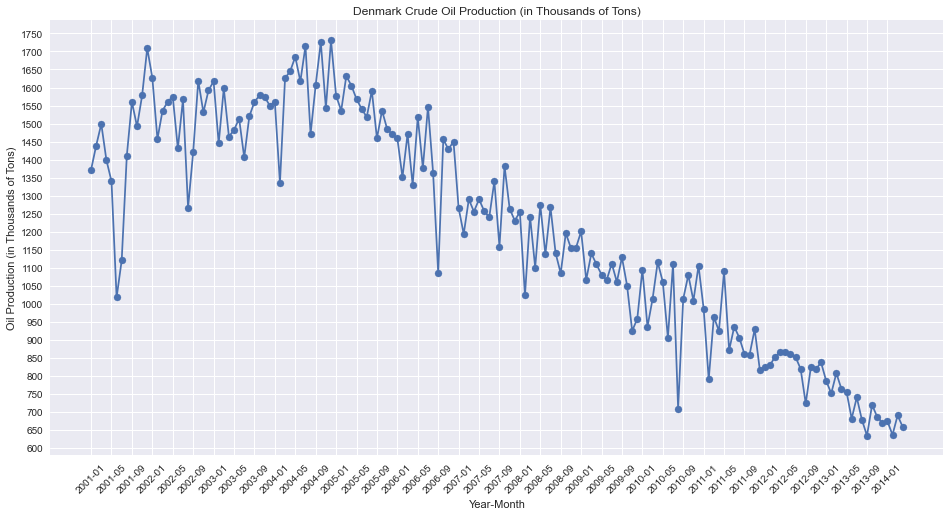

In [318]:
'''Graph of the Time searies'''

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(data_1_clean['Production'])
    plt.scatter(x = data_1_clean.index.tolist(), y = data_1_clean['Production'])
    plt.xticks([i for i in data_1_clean.index.tolist() if i[5:] == '01' or i[5:] == '05' or i[5:] == '09'], rotation = 45)
    plt.yticks([i for i in range(600, 1800, 50)])
    plt.title('Denmark Crude Oil Production (in Thousands of Tons)')
    plt.ylabel('Oil Production (in Thousands of Tons)')
    plt.xlabel('Year-Month')
    plt.show()

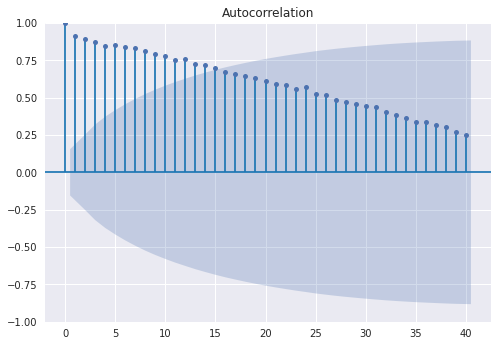

In [319]:
with plt.style.context('seaborn'):
    fig = plot_acf(data_1_clean, lags=len(data_1_clean)/4)

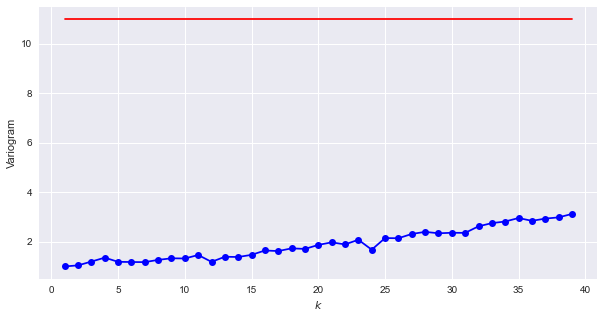

In [320]:
r1 = ts.acf(data_1_clean['Production'], nlags=int(len(data_1_clean)/4))[1]
base_var  = np.var(data_1_clean['Production'])

variogram = pd.DataFrame(index = [i for i in range(1,int(len(data_1_clean)/4))])
variogram['lagged'] = [np.var(np.array(data_1_clean['Production'].iloc[i:]) - np.array(data_1_clean['Production'].iloc[:-i]))/np.var(np.diff(data_1_clean['Production'])) for i in range(1,int(len(data_1_clean)/4))]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(10,5))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

\normalsize

### Comments{-}

#### Timeseries:{-}

It seemed to have small positive trend but now looks like it has a negative trend since end of Q1 and/or start of Q2 2005. One might be able to say that it is reverting around this negative trend. 

#### ACF:{-} 

One can sees that the autocorrelation decays very slowly.

#### Variogram:{-}

We set $\frac{T}{4}$ as our "best practice" number of lags and we can see that it never passes the asymptote.

All plots suggest that the timeseries is not stationary.

\scriptsize

## Apply both first-order and double exponential smoothing to develop two forecasting models for crude oil production. Plot two smoothed fits on the same axes with the original data and visually compare their performance.

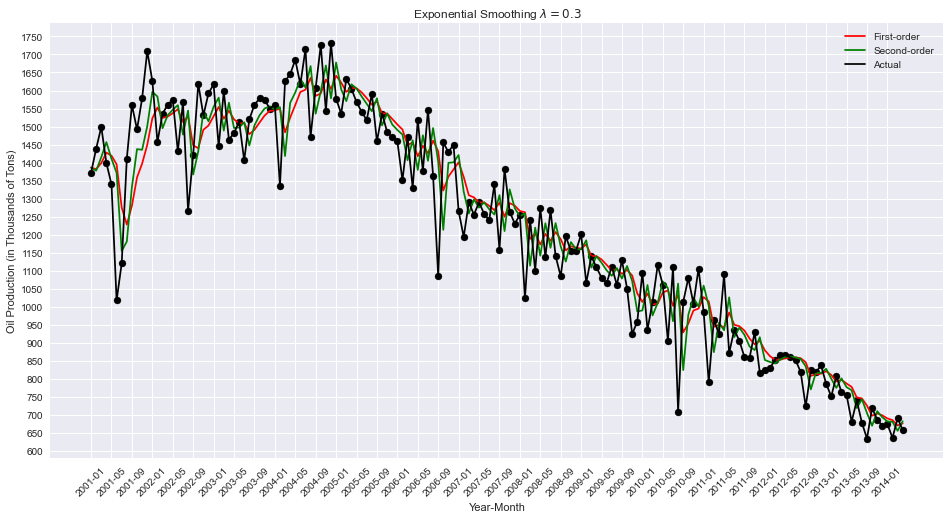

In [321]:
fit_1 = ExponentialSmoothing(data_1_clean['Production'].values, initialization_method='heuristic', use_boxcox=0.3).fit()
data_1_clean['fitted 1'] = fit_1.fittedvalues
fit_2 = ExponentialSmoothing(data_1_clean['fitted 1'].values, initialization_method='heuristic', use_boxcox=0.3).fit()
data_1_clean['fitted 2'] = 2*fit_1.fittedvalues - fit_2.fittedvalues

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(data_1_clean['fitted 1'], c = 'Red', label = 'First-order')
    plt.plot(data_1_clean['fitted 2'], c = 'Green', label = 'Second-order')
    plt.plot(data_1_clean['Production'], label = 'Actual', c='Black')
    plt.scatter(data_1_clean.index.tolist(),data_1_clean['Production'], c= 'Black')
    plt.xticks([i for i in data_1_clean.index.tolist() if i[5:] == '01' or i[5:] == '05' or i[5:] == '09'], rotation = 45)
    plt.yticks([i for i in range(600, 1800, 50)])
    plt.legend()
    plt.ylabel('Oil Production (in Thousands of Tons)')
    plt.xlabel('Year-Month')
    plt.title('Exponential Smoothing $\lambda = 0.3$')
    plt.show()

\normalsize

### Comments{-}

We can clearly see that the second order exponential smoothing has a better fit but mostly due to the fact that it had a larger variance. 

\scriptsize

## Apply a first difference on the raw data, plot the data and comment on any features that you observe from the graph. Generate and interpret the sample ACF and variogram.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


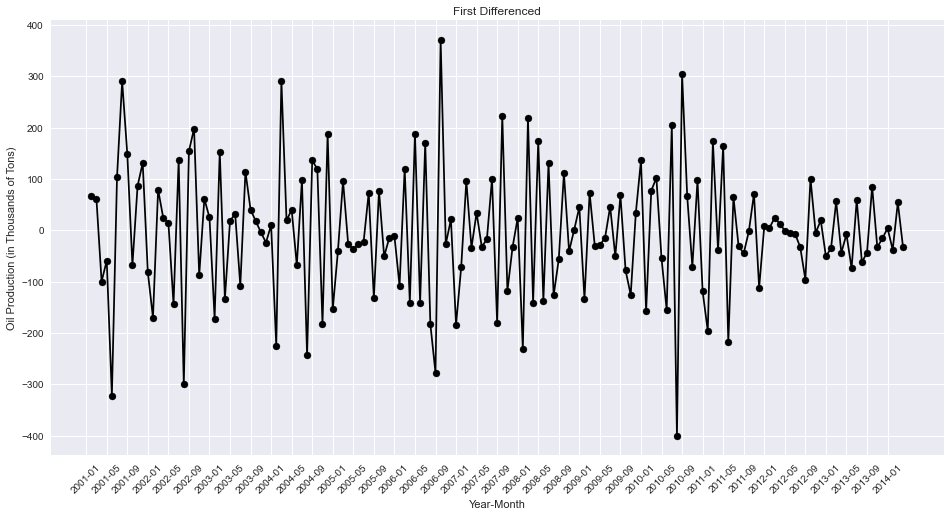

In [322]:
data_1_clean['First diff'] = data_1_clean['Production'].diff()
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(data_1_clean['First diff'], c='Black')
    plt.scatter(data_1_clean.index.tolist(),data_1_clean['First diff'], c= 'Black')
    plt.xticks([i for i in data_1_clean.index.tolist() if i[5:] == '01' or i[5:] == '05' or i[5:] == '09'], rotation = 45)
    #plt.yticks([i for i in range(600, 1800, 50)])
    plt.legend()
    plt.ylabel('Oil Production (in Thousands of Tons)')
    plt.xlabel('Year-Month')
    plt.title('First Differenced')
    plt.show()

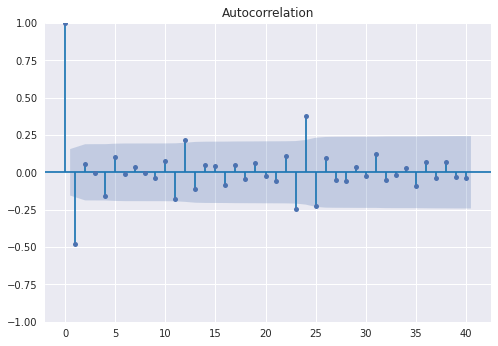

In [323]:
with plt.style.context('seaborn'):
    fig = plot_acf(data_1_clean['First diff'].dropna(), lags=len(data_1_clean)/4)

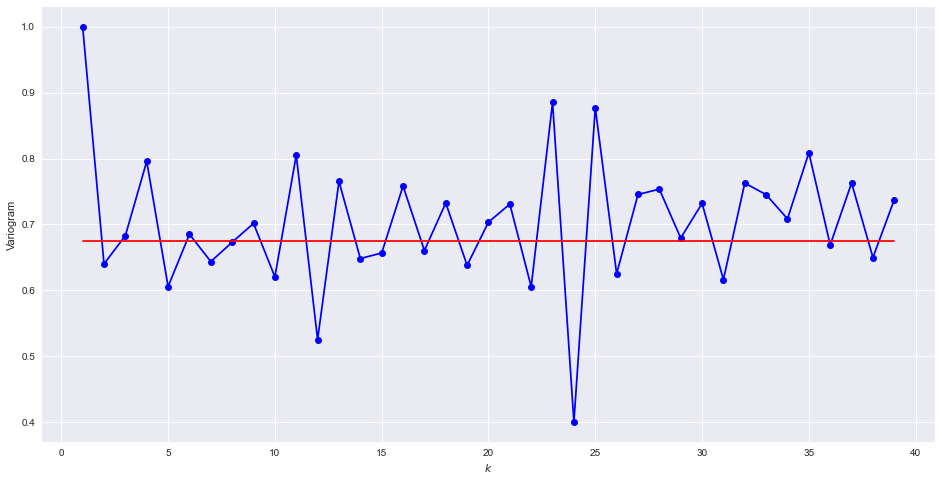

In [324]:
r1 = ts.acf(data_1_clean['First diff'].dropna(), nlags=int(len(data_1_clean)/4))[1]
base_var  = np.var(data_1_clean['First diff'].dropna())

variogram = pd.DataFrame(index = [i for i in range(1,int(len(data_1_clean)/4))])
variogram['lagged'] = [np.var(np.array(data_1_clean['First diff'].dropna().iloc[i:]) - np.array(data_1_clean['First diff'].dropna().iloc[:-i]))/np.var(np.diff(data_1_clean['First diff'].dropna())) for i in range(1,int(len(data_1_clean)/4))]
variogram ['asymp'] = [1/(1-r1) for i in range(len(variogram))]

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(variogram['lagged'], c = 'Blue', marker = 'o')
    plt.plot(variogram['asymp'], c = 'Red')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Variogram')
    plt.show()

\normalsize

### Comments{-}

#### Timeseries:{-}

We can see that by performing the first differe3nce method, we see that this series is now clearly reverting around constant mean/value.

#### ACF:{-} 

The decay is very quick followed by a sinusoidal pattern.

#### Variogram:{-}

One can see that the variogram reaches the asymptote quickly and ossolates around said asymptote.

All plots suggest that first differenced series is sationary.

\scriptsize

## Apply first-order exponential smoothing on the differenced data and use the smoothed difference to develop a forecasting model for crude oil production (i.e. $\hat{y}_{t+1} = y_t+ \hat{d}_{t+1}, t = 1, 2 \text{...}$ and $\hat{y}_1 = y_1; \hat{d}_{t+1}$ is the smoothed difference at time $t + 1$). Compare the result to (b) where the smoothing was done on the raw (undifferenced) data.

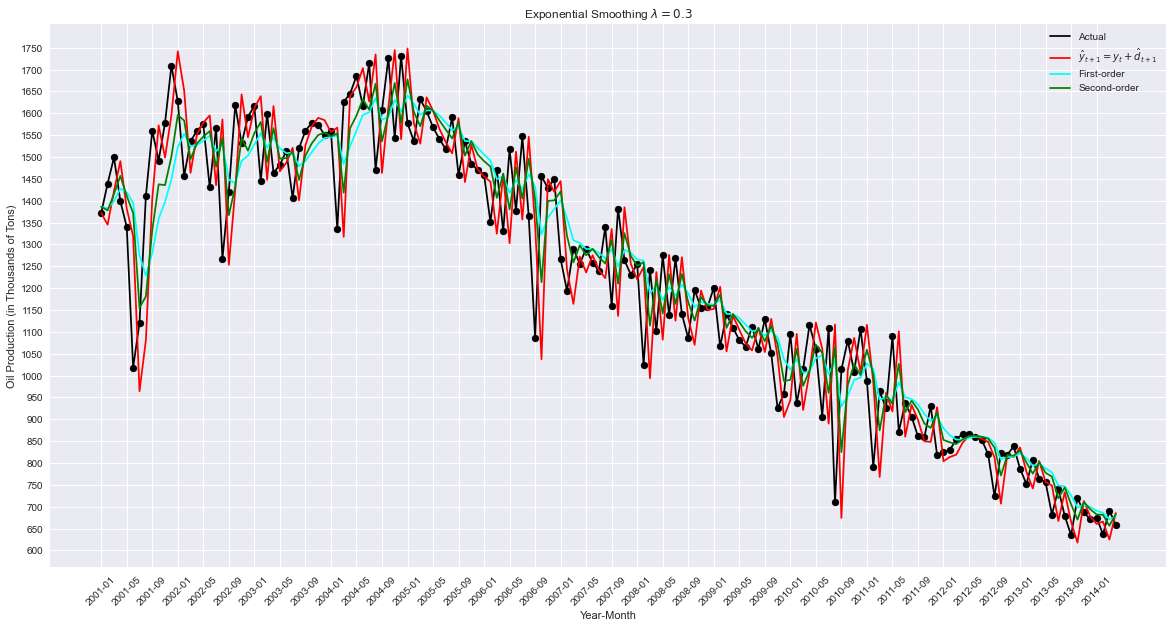

In [325]:
fit_ex_1_diff = ExponentialSmoothing(data_1_clean['First diff'].dropna().values, trend='add').fit()
diff_smooth_lst = [fit_ex_1_diff.fittedvalues[i] for i in range(len(fit_ex_1_diff.fittedvalues))]
diff_smooth_lst.insert(0,np.nan)
data_1_clean['fitted ex 1 diff'] = diff_smooth_lst
data_1_clean = data_1_clean.fillna(0)
data_1_clean['final fit'] = [
                                data_1_clean['Production'].iloc[i-1] + data_1_clean['fitted ex 1 diff'].iloc[i]
                                if i >0 else data_1_clean['Production'].iloc[i]
                                for i in range(len(data_1_clean))
                            ]
                            
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(data_1_clean['Production'], label = 'Actual', c='Black')
    plt.plot(data_1_clean['final fit'], c = 'red', label = '$\hat{y}_{t+1} = y_t+ \hat{d}_{t+1}$')
    plt.plot(data_1_clean['fitted 1'], c = 'Cyan', label = 'First-order')
    plt.plot(data_1_clean['fitted 2'], c = 'Green', label = 'Second-order')
    plt.scatter(data_1_clean.index.tolist(),data_1_clean['Production'], c= 'Black')
    plt.xticks([i for i in data_1_clean.index.tolist() if i[5:] == '01' or i[5:] == '05' or i[5:] == '09'], rotation = 45)
    plt.yticks([i for i in range(600, 1800, 50)])
    plt.legend()
    plt.ylabel('Oil Production (in Thousands of Tons)')
    plt.xlabel('Year-Month')
    plt.title('Exponential Smoothing $\lambda = 0.3$')
    plt.show()

\normalsize

### Comments{-}

One can see that our new model, $\hat{y}_{t+1} = y_t+ \hat{d}_{t+1}$ where $\hat{y}_{1} = y_1$ and $\hat{d}_{t+1}$ is the exponentially smoothed difference at time $t+1$, has a better fit than both the first and second exponentially smoothed regressions. 

\scriptsize
\pagebreak

# (60 points) Table B.23 shows the weekly data of positive laboratory test results (in percentage) of influenza from the 40th week of 1997 to the 31st week of 2014.

## Manage to read the data into R (or Python if choose to use) with corresponding time indices. (Note that you need to convert the information of year and week number into a valid time index) Explain how you convert the excel worksheet into an operable object in R (or Python).

\normalsize

For correctness I start by visiting the url for later in the problem. I find that week 40, 1997 ends on Oct 4, 1997. This shows me that they are measuring from Saturday to Saturday. The implimentation is simple from there. I create an empty list, which get filled with the new index, and initialize the starting date. I then figure out the true n x m matrix for how many weeks and subtract for the double counting. I then calculate the area of the grid and subtract all "-" values to get the correct number of dates needed. I then iterate using this "total week value" and add 7*i days where i = the week number. This then gives me the correct week ending dates for all weeks. I finally get a list of the percentages without the dashes and create a dataframe. 

\scriptsize

In [326]:
'''Importing the data'''

data_2 = pd.read_excel('data.xlsx',sheet_name='B.23-INFLUENZA', skiprows=4, index_col='Week')

starting_date = datetime.date(1997,10,4)                # Starting Date
end_of_week_dates = []                                  # Empty index list

col_1_dash = sum([1 if data_2.iloc[i,0] == '-' else 0 for i in range(len(data_2.index))])                           # First column number of dashes
col_last_dash = sum([1 if data_2.iloc[i,-1] == '-' else 0 for i in range(len(data_2.index))])                       # Second column number of dashes
last_row_dash = sum([1 if data_2.iloc[-1,i] == '-' else 0 for i in range(len(data_2.columns))])-1                   # Last row number of dashes - 1 for double count
actual_nxm = len(data_2.index.tolist())*len(data_2.columns.tolist()) - (col_1_dash+last_row_dash+col_last_dash)     # Correct area of the grid (total weeks)

''' The iteration'''
for i in range(actual_nxm):
    if i == 0:
        end_of_week_dates.append(starting_date.strftime('%Y-%m-%d'))                            # First date is 10/4/1997
    elif i > 0:                                         
        new_date = starting_date + datetime.timedelta(days = 7*(i))                             # Days * Weeks gets added to the starting date
        end_of_week_dates.append(new_date.strftime('%Y-%m-%d'))                                 # New date gets added to empty list
    
end_of_week_dates.sort() 

# Data without dashes
percentages = [data_2.iloc[j,i] for i in range(len(data_2.columns.tolist())) for j in range(len(data_2.index.tolist())) if data_2.iloc[j,i] != '-'] 
data_2_indexed = pd.DataFrame(percentages,index = end_of_week_dates, columns=['pct'])   # Creation of final dataframe
for i in range(len(data_2_indexed)):
    if data_2_indexed.iloc[i][0] == 'NR':
        data_2_indexed.iloc[i] = np.nan

data_2_indexed.index = pd.DatetimeIndex(data_2_indexed.index)
data_2_indexed.index.freq = 'W-SAT'

## Notice that these data have a number of missing values in year 1998-2002. Read the book section $\S 1.4.3$ for data imputation, evaluate the structure of data by plotting the subset of data where there is no missing values(say 2003 and on) and apply an imputation scheme that you think of as appropriate for the data. Display the imputed data in a series plot and explain your choice. (note that "xts" package provides several functions for imputation, though they might not be your choice)

### Graph of No Missing Data{-}

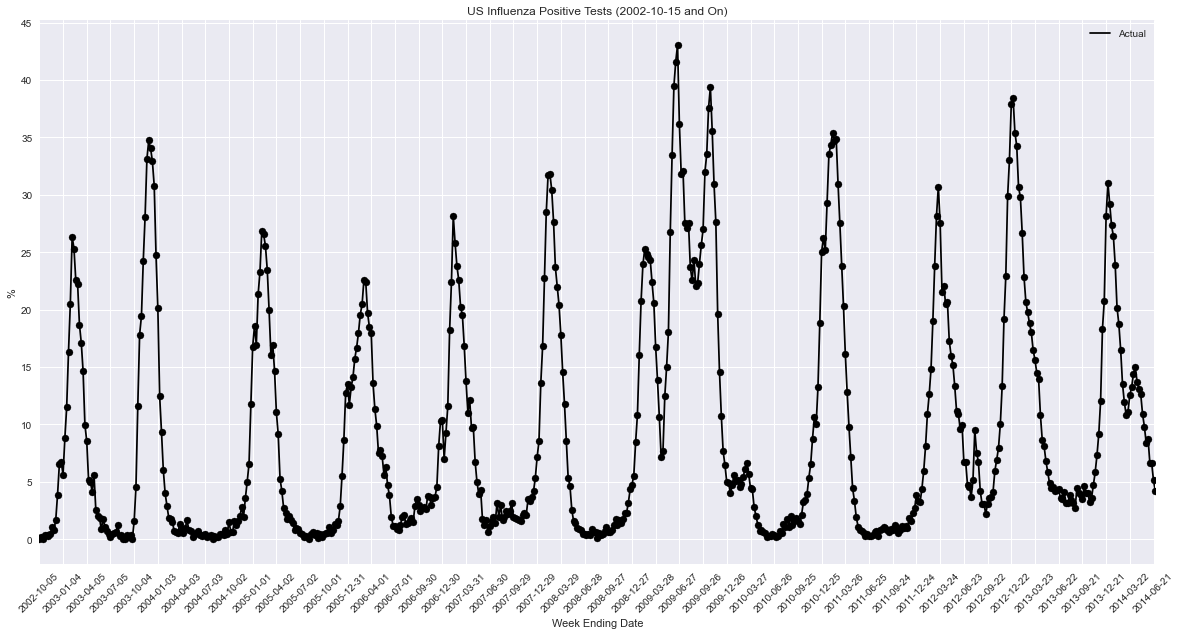

In [327]:
'''Plot of non missing data starting from last empty value'''
data_2_index_noNR = data_2_indexed.loc['2002-10':]
data_2_index_noNR.index = pd.DatetimeIndex(data_2_index_noNR.index)
data_2_idx_noNR = data_2_index_noNR.index.tolist()
xtick = dates.drange(data_2_idx_noNR[0], data_2_idx_noNR[-1], datetime.timedelta(weeks = 13))
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    plt.plot(data_2_index_noNR, label = 'Actual', c='Black')
    plt.scatter(data_2_index_noNR.index.tolist(),data_2_index_noNR.values, c= 'Black')
    plt.legend()
    plt.xticks(xtick, rotation = 45)
    plt.xlim([xtick[0], data_2_index_noNR.index.tolist()[-1]])
    plt.yticks([i for i in range(0,50, 5)])
    plt.ylabel('%')
    plt.xlabel('Week Ending Date')
    plt.title('US Influenza Positive Tests (2002-10-15 and On)')
    plt.show()

\normalsize

### Explination{-}

We can clearly see that the data follows a seasonal pattern. I first started by trying to use the variation of mean value imputation:

$$
y_j^* = \frac{1}{2k} \left(\sum_{t=j-k}^{j-1}y_t + \sum_{t=j+1}^{j+k}y_t \right)
$$

I made multiple funtions for it yet did yield proper results. I then chose to use the function I found here 

\scriptsize
https://imputena.readthedocs.io/en/latest/_modules/imputena/simple_imputation/seasonal_interpolation.html 
\normalsize

This function did not actually work as it must be old a depricated. Thus I had to create my own function which would work.

The function is trying to replicate **na_seadec** in R. 

The reason for this choice is that simply applying a linear regressor without a seasonal component would yield improper results and we have long stretches of missing values or else the first method would have been chosen. By performing a seasonal decomposition and then adding it back in we were able to get a better fit. Our method did yield some negative values (smallest being $-0.5+$) and since the way data was collected/measured it was impossible to have a negative percentage. Thus we just changed these to $0$.

\scriptsize

In [328]:
'''Function'''
def seasonal_interpolate_series(data, column, model = 'additive', method='linear', direction = 'both'):
    """Performs interpolation with seasonal adjustment on a time series or a
data frame containing time series. First, the time series gets
decomposed according to the decomposition model (additive or
multiplicative). Then, the missing values are interpolated using the
interpolation method (linear, cubic or quadratic) on a series consisting of
only the trend and irregular components. Finally, the seasonality is
added back to the series."""
    # This function aways returns a copy. The parent function takes care of
    # assigning its results to the same series or data frame if the
    # operation is to be made inplace.
    res = data.copy()
    # kwargs for the pandas interpolate() function:
    int_kwargs = {'limit_direction': direction}
    # Missing data index:
    na_index = res[res[column].isnull()].index.tolist()
    # Dropping the time index:
    res = res.reset_index()
    res = res.drop(['index'], axis = 1)
    res[column] = res[column].astype(float)
    # Interpolate NAs:
    temp = res.interpolate(method=method, **int_kwargs)
    temp.index = pd.DatetimeIndex(data.index)
    # Decompose:
    dr = seasonal_decompose(temp, model=method)
    # Join trend and irregular component (timeseries without seasonality):
    if model == 'multiplicative':
        data_no_seasonality = dr.trend * dr.resid
    if model == 'additive':
        data_no_seasonality = dr.trend + dr.resid
    # Fill in NA values:
    data_no_seasonality[na_index] = np.nan
    # Interpolate data without seasonality:
    data_no_seasonality_imputed = data_no_seasonality.interpolate(
        method=method, **int_kwargs)
    # Add back seasonality:
    if model == 'multiplicative':
        data_imputed = data_no_seasonality_imputed * dr.seasonal
    if model == 'additive':
        data_imputed = data_no_seasonality_imputed + dr.seasonal
    # Merge interpolated values into original timeseries:
    res.index = data.index
    data_imputed.index = data.index
    res.loc[na_index, column] = data_imputed.loc[na_index]
    # Return the seasonally interpolated series:
    return res

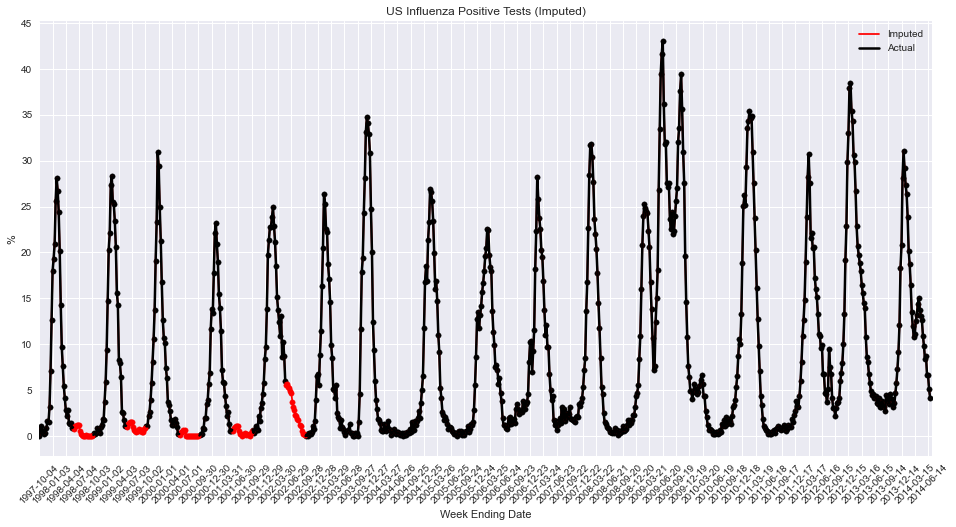

In [329]:
test = seasonal_interpolate_series(data_2_indexed, column='pct')
test.index = pd.DatetimeIndex(test.index)
# Changing negative values to close to zero for next question
test['pct'] = [
    test['pct'][i] if test['pct'][i] > 0 else 0.000001
    for i in test.index.tolist()
]


xtick = dates.drange(test.index.tolist()[0], test.index.tolist()[-1], delta=datetime.timedelta(weeks=13))
missing_idx = pd.DatetimeIndex(data_2_indexed[data_2_indexed['pct'].isnull()].index.tolist())
imputed_values = pd.DataFrame(index = missing_idx, columns=['pct'])
imputed_values['pct'] = test.loc[missing_idx, 'pct']

graph_original = data_2_indexed.copy()
graph_original.index = pd.DatetimeIndex(graph_original.index)

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(test, label = 'Imputed', c='Red')
    plt.plot(graph_original, linewidth = 2.5, label = 'Actual', c='Black', )
    plt.scatter(graph_original.index.tolist(), graph_original.values, c= 'Black', s=30)
    #plt.plot(imputed_values, label = 'Imputed', c='Blue')
    plt.scatter(imputed_values.index.tolist(), imputed_values.values, c= 'Red', s=30)
    #plt.scatter(test.index.tolist(), test.values, c= 'Black', s=30)
    #plt.scatter(imputed_vals.index.tolist(),imputed_vals.values, c= 'Blue', label = 'Imputed')
    plt.xticks(xtick, rotation = 45)
    plt.xlim([xtick[0], test.index.tolist()[-1]+datetime.timedelta(weeks = 2)])
    plt.yticks([i for i in range(0,50, 5)])
    plt.legend()
    plt.ylabel('%')
    plt.xlabel('Week Ending Date')
    plt.title('US Influenza Positive Tests (Imputed)')
    plt.show()

## Use the data from 1997-2013 to develop a multiplicative Winters-type exponential smoothing model for the imputed data. Evaluate the forecast errors to see if they significantly differ from a set of white noises (in addition to ACF, consider using Ljung-Box test which are available in both R and Python).

\normalsize

Since the Holt-Winters model in statsmodel api needs to have the data be $> 0$ and not $\ge 0$, we change the 0 values we imputed to be small but not 0. 

\scriptsize

c:\Users\Chaz\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


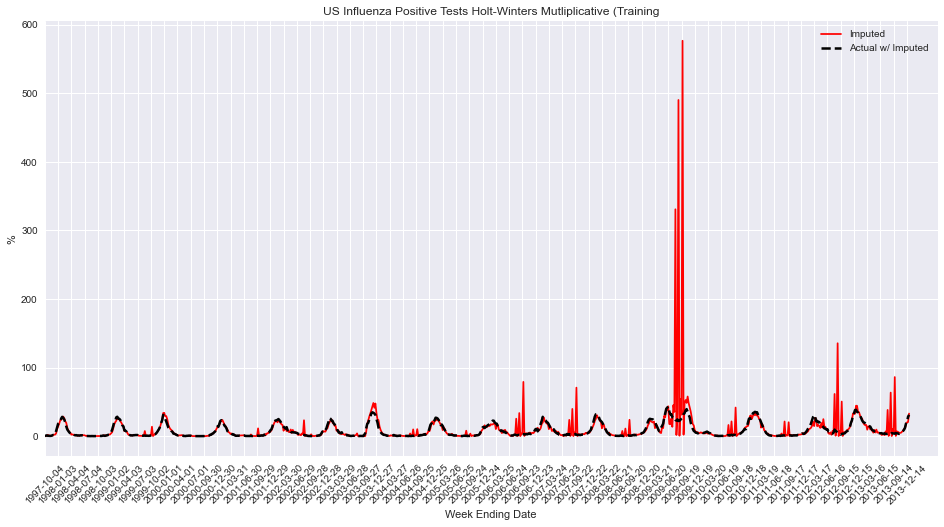

In [330]:
HW = test.copy()
tr_idx_chop = HW.loc[:'2013'].index.tolist()[-1] 
HW_tr_data = HW.loc[:tr_idx_chop]
HW_tr_fit = HW_tr_data.copy()

model = ExponentialSmoothing(HW_tr_data['pct'], seasonal = 'mul').fit()
#model = ETSModel(HW_tr_data['pct'], seasonal_periods=52, seasonal = 'mul')
#fit = model.fit()
HW_tr_fit['pct'] = model.fittedvalues


with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(HW_tr_fit, label = 'Imputed', c='Red')
    plt.plot(test.loc[:tr_idx_chop], linewidth = 2.5, label = 'Actual w/ Imputed', c='Black', linestyle = 'dashed')
    #plt.scatter(graph_original.index.tolist(), graph_original.values, c= 'Black', s=30)
    #plt.plot(imputed_values, label = 'Imputed', c='Blue')
    #plt.scatter(imputed_values.index.tolist(), imputed_values.values, c= 'Red', s=30)
    #plt.scatter(test.index.tolist(), test.values, c= 'Black', s=30)
    #plt.scatter(imputed_vals.index.tolist(),imputed_vals.values, c= 'Blue', label = 'Imputed')
    plt.xticks(dates.drange(HW_tr_fit.index.tolist()[0], tr_idx_chop, datetime.timedelta(weeks=13)), rotation = 45)
    plt.xlim([xtick[0], test.index.tolist()[-1]+datetime.timedelta(weeks = 2)])
    #plt.yticks([i for i in range(0,50, 5)])
    plt.legend()
    plt.ylabel('%')
    plt.xlabel('Week Ending Date')
    plt.title('US Influenza Positive Tests Holt-Winters Mutliplicative (Training')
    plt.show()

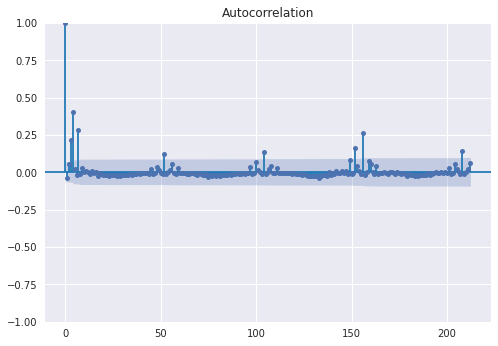

In [331]:
with plt.style.context('seaborn'):
    fig = plot_acf(model.resid, lags=int(len(HW_tr_data)/4))

In [332]:
ljb_df = sm.acorr_ljungbox(model.resid, lags = [1,4,13,52])
md(ljb_df.to_markdown())

|    |   lb_stat |   lb_pvalue |
|---:|----------:|------------:|
|  1 |   1.35044 | 0.245201    |
|  4 | 183.492   | 1.32603e-38 |
| 13 | 252.584   | 1.86023e-46 |
| 52 | 274.126   | 6.21135e-32 |

In [333]:
DB = sm.durbin_watson(model.resid)
DB

2.0638140766697735

\normalsize

### Evaluation{-}

ACF: We can see that there seems to be no autocorrelation as it decays quickly and shows somewhat of a sinusoidal pattern. Yet the pattern has sharp jumps for seasonality. Meaning at times of peak values, the correlations jump.  

Ljung-Box Test: We tested over lag $= 1, 4,13, 52$ based on the timeseries graph's seasonality. These lags correspond to 1 week, 1 month, 1 quater, and 1 year. Based on these lags and the p-value, we can see that, except for lag $=$ 1 value, they differ from white noise significantly.  

Durbin-Watson: Just for safe keeping I am also using the DB test. This also showed to be in the comfortable range of $1.5-2.5$. This shows it most likely has serial correlation. 

\scriptsize

## Use this model to make one-week-ahead forecasts for the year 2014. Plot the forecasts overlapped with the raw data and report the sum of the forecast errors. Discuss the reasonableness of the forecasts.

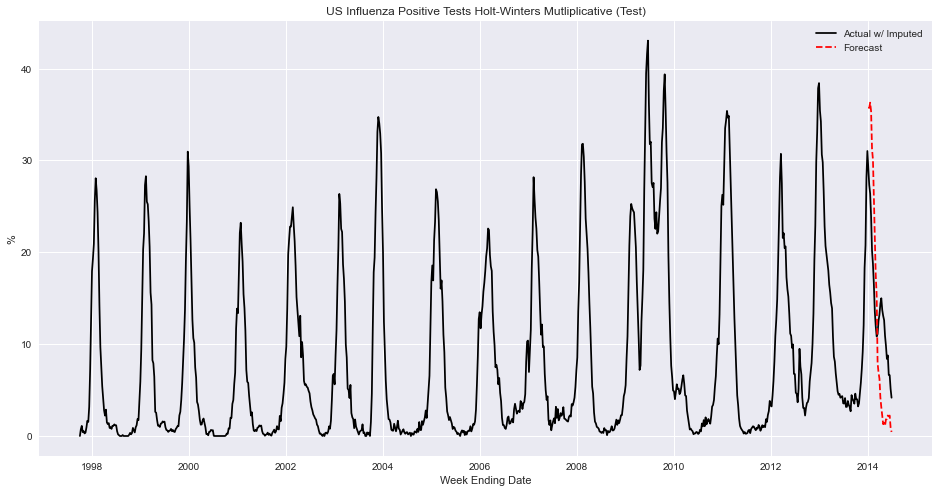

In [334]:
# Testing Data
data_2_indexed.index = pd.DatetimeIndex(data_2_indexed.index)
test_idx_chop = HW.loc['2014':].index.tolist()[0] 
HW_test = pd.DataFrame(index = data_2_indexed.loc[test_idx_chop:].index, columns=['actual', 'forecasted'])
HW_test['actual'] = [i[0] for i in data_2_indexed.loc[test_idx_chop:].values]
HW_test['forecasted'] = model.predict(start=HW_test.index[0], end=HW_test.index[-1])

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    #plt.plot(HW_tr_fit, label = 'Training', c='Blue')
    plt.plot(test, label = 'Actual w/ Imputed', c='Black')
    plt.plot(HW_test['forecasted'], label = 'Forecast', c='Red', linestyle = 'dashed')
    #plt.plot(HW_test['actual'], label = 'Actual', c='Black')
    #plt.scatter(graph_original.index.tolist(), graph_original.values, c= 'Black', s=30)
    #plt.plot(imputed_values, label = 'Imputed', c='Blue')
    #plt.scatter(imputed_values.index.tolist(), imputed_values.values, c= 'Red', s=30)
    #plt.scatter(test.index.tolist(), test.values, c= 'Black', s=30)
    #plt.scatter(imputed_vals.index.tolist(),imputed_vals.values, c= 'Blue', label = 'Imputed')
    #plt.xticks(dates.drange(HW_tr_fit.index.tolist()[0], tr_idx_chop, datetime.timedelta(weeks=13)), rotation = 45)
    #plt.xlim(dates.dran)
    #plt.yticks([i for i in range(0,50, 5)])
    plt.legend()
    plt.ylabel('%')
    plt.xlabel('Week Ending Date')
    plt.title('US Influenza Positive Tests Holt-Winters Mutliplicative (Test)')
    plt.show()

In [335]:

HW_test['errors'] = HW_test['actual'] - HW_test['forecasted']
sum_errors = np.sum(HW_test['errors'])
md('''The sum of the forcasted errors is ${}$'''.format(sum_errors))

The sum of the forcasted errors is $33.58116674421697$

\normalsize

I do not think this model is very reasonable. It seems to be modeling the "highs" to "high". Specifically if there is a peak, the day following this peak is ussually too high. Also Variation in the training data as well as fit does not seem to be realistic. 

\scriptsize

## Repeat (c) and (d) but with an additive Winters-type model.

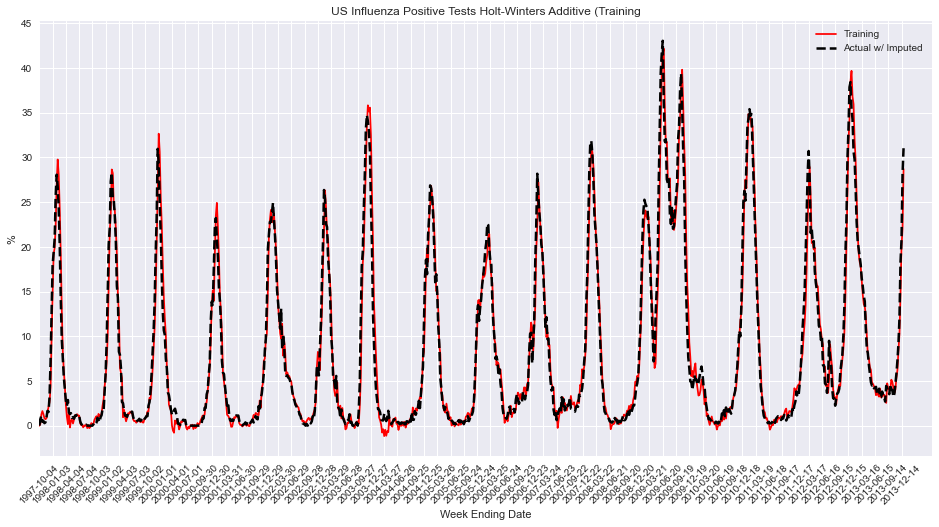

In [336]:
HW = test.copy()
tr_idx_chop = HW.loc[:'2013'].index.tolist()[-1] 
HW_tr_data = HW.loc[:tr_idx_chop]
HW_tr_fit = HW_tr_data.copy()

model = ExponentialSmoothing(HW_tr_data['pct'], seasonal = 'add').fit()
HW_tr_fit['pct'] = model.fittedvalues

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(HW_tr_fit, label = 'Training', c='Red')
    plt.plot(test.loc[:tr_idx_chop], linewidth = 2.5, label = 'Actual w/ Imputed', c='Black', linestyle = 'dashed')
    #plt.scatter(graph_original.index.tolist(), graph_original.values, c= 'Black', s=30)
    #plt.plot(imputed_values, label = 'Imputed', c='Blue')
    #plt.scatter(imputed_values.index.tolist(), imputed_values.values, c= 'Red', s=30)
    #plt.scatter(test.index.tolist(), test.values, c= 'Black', s=30)
    #plt.scatter(imputed_vals.index.tolist(),imputed_vals.values, c= 'Blue', label = 'Imputed')
    plt.xticks(dates.drange(HW_tr_fit.index.tolist()[0], tr_idx_chop, datetime.timedelta(weeks=13)), rotation = 45)
    plt.xlim([xtick[0], test.index.tolist()[-1]+datetime.timedelta(weeks = 2)])
    plt.yticks([i for i in range(0,50, 5)])
    plt.legend()
    plt.ylabel('%')
    plt.xlabel('Week Ending Date')
    plt.title('US Influenza Positive Tests Holt-Winters Additive (Training')
    plt.show()

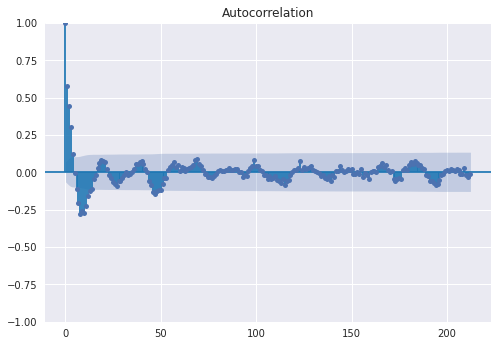

In [337]:
with plt.style.context('seaborn'):
    fig = plot_acf(model.resid, lags=int(len(HW_tr_data)/4))

In [338]:
ljb_df = sm.acorr_ljungbox(model.resid, lags = [1,4,13,52])
md(ljb_df.to_markdown())

|    |   lb_stat |    lb_pvalue |
|---:|----------:|-------------:|
|  1 |   280.595 | 5.57027e-63  |
|  4 |   541.37  | 7.5336e-116  |
| 13 |   856.999 | 8.45535e-175 |
| 52 |  1025.45  | 8.0226e-181  |

In [339]:
DB = sm.durbin_watson(model.resid)
DB

0.8496010424456529

\normalsize

### Evaluation{-}

ACF: We can see that there seems to be no autocorrelation as is decays quickly and shows somewhat of a sinusoidal pattern.

Ljung-Box Test: We tested over lag $= 1, 4,13, 52$ based on the timeseries graph's seasonality. These lags correspond to 1 week, 1 month, 1 quater, and 1 year. Based on these lags and the p-value, we can say that the residuals differ significantly from white noise.  


Durbin-Watson: Just for safe keeping I am also using the DB test. This also showed to be out of the comfortable range of $1.5-2.5$. This shows it most likely has serial correlation. 

\scriptsize

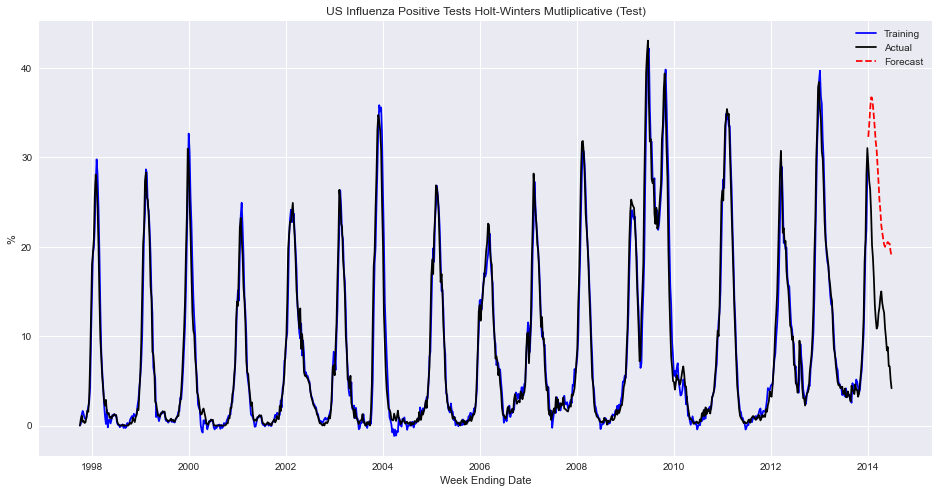

In [340]:
# Testing Data

test_idx_chop = HW.loc['2014':].index.tolist()[0] 
HW_test_add = pd.DataFrame(index = data_2_indexed.loc[test_idx_chop:].index, columns=['actual', 'forecasted'])
HW_test_add['actual'] = [i[0] for i in data_2_indexed.loc[test_idx_chop:].values]
HW_test_add['forecasted'] = model.predict(start=HW_test_add.index[0], end=HW_test_add.index[-1])

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(HW_tr_fit, label = 'Training', c='Blue')
    plt.plot(test, label = 'Actual', c='Black')
    plt.plot(HW_test_add['forecasted'], label = 'Forecast', c='Red', linestyle = 'dashed')
    # plt.plot(HW_test_add['actual'], label = 'Actual', c='Black')
    #plt.scatter(graph_original.index.tolist(), graph_original.values, c= 'Black', s=30)
    #plt.plot(imputed_values, label = 'Imputed', c='Blue')
    #plt.scatter(imputed_values.index.tolist(), imputed_values.values, c= 'Red', s=30)
    #plt.scatter(test.index.tolist(), test.values, c= 'Black', s=30)
    #plt.scatter(imputed_vals.index.tolist(),imputed_vals.values, c= 'Blue', label = 'Imputed')
    #plt.xticks(dates.drange(HW_tr_fit.index.tolist()[0], tr_idx_chop, datetime.timedelta(weeks=13)), rotation = 45)
    #plt.xlim(dates.dran)
    #plt.yticks([i for i in range(0,50, 5)])
    plt.legend()
    plt.ylabel('%')
    plt.xlabel('Week Ending Date')
    plt.title('US Influenza Positive Tests Holt-Winters Mutliplicative (Test)')
    plt.show()

In [341]:
HW_test_add['errors'] = HW_test_add['actual'] - HW_test_add['forecasted']
sum_errors = np.sum(HW_test_add['errors'])
md('''The sum of the forcasted errors is ${}$'''.format(sum_errors))

The sum of the forcasted errors is $-327.18421174708277$

\normalsize

I think this is an alright fit. The fit of this model needs to and can be improved. Namely to make it stationary or perform something regularize the data. As for predictions is it okay while maybe being "overpredicting" but it is following the line quite well. 

## Compare the performance of the additive and the multiplicative model. Comment on the superiority between the two.

The training fit for the multiplicative model is not great except for one cycle of the seasonal variation. Besides that, every other measure is quite solid for stationarity. DB test is in the correct range as well as the ACF test showing quick decay and sinusodal pattern. Yet we look at the fit for the additive we can see that there is definately better fit for the training data even though the tests show poor results compared to the multiplicative model. With the graphically poor fit and even though the additive model shows less than exceptional scores for the tests performed on them, we will pick the additive as having a superior modeling capability. 

\scriptsize

## Visit https://gis.cdc.gov/grasp/uview/uportaldashboard.html and download the data for the rest of year 2014 to 2021. Manage to combine the data and use the winner you pick from (e) to fit the whole set of data (1997-2020). Comment on the result.

In [342]:
new_data = pd.read_excel('Last_data.xlsx')
prior = data_2_indexed. index.tolist()
last_prior = prior[-1]
dates_new_idx = [last_prior+datetime.timedelta(weeks =1)*i for i in range(1, len(new_data)+1)]
new_data_idx_df = pd.DataFrame(index = dates_new_idx, columns = ['pct'])
new_data_idx_df['pct'] = new_data['PERCENT POSITIVE']
combined_idx = prior+dates_new_idx
combined = pd.DataFrame(index = combined_idx, columns = ['pct'])
#combined['pct'] = [
                    #test['pct'][i] 
                    #if i in test.index.tolist() else new_data_idx_df['pct'][i]
                    #for i in combined_idx
                #]
combined['pct'] = test['pct'].tolist() + new_data['PERCENT POSITIVE'].tolist()
combined.index = pd.DatetimeIndex(combined.index)
combined.index.freq = 'W-SAT'

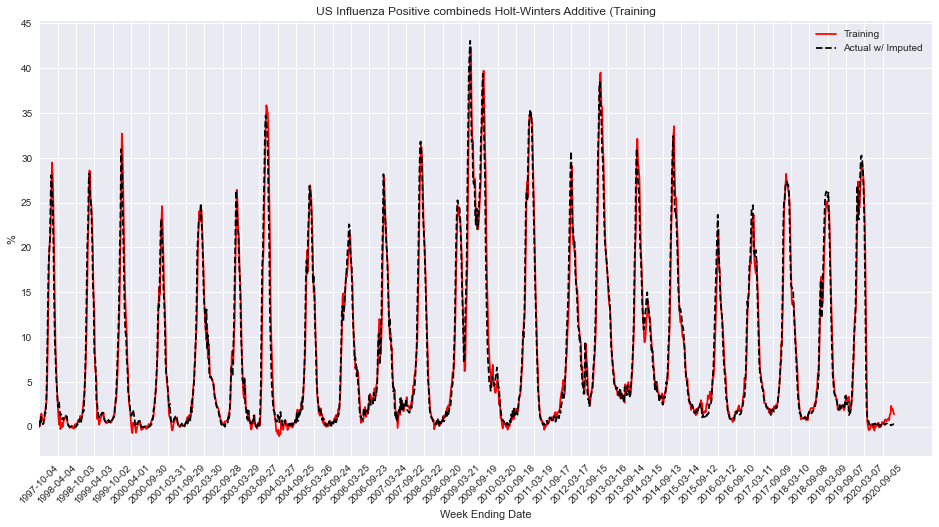

In [343]:
HW = combined.copy()
tr_idx_chop = HW.loc[:'2020'].index.tolist()[-1] 
HW_tr_data = HW.loc[:tr_idx_chop]
HW_tr_fit = HW_tr_data.copy()

model = ExponentialSmoothing(HW_tr_data['pct'], seasonal='additive').fit()
HW_tr_fit['pct'] = model.fittedvalues

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(16,8))
    ax = plt.axes()
    plt.plot(HW_tr_fit, label = 'Training', c='Red')
    plt.plot(combined.loc[:tr_idx_chop], label = 'Actual w/ Imputed', c='Black', linestyle = 'dashed')
    #plt.scatter(graph_original.index.tolist(), graph_original.values, c= 'Black', s=30)
    #plt.plot(imputed_values, label = 'Imputed', c='Blue')
    #plt.scatter(imputed_values.index.tolist(), imputed_values.values, c= 'Red', s=30)
    #plt.scatter(combined.index.tolist(), combined.values, c= 'Black', s=30)
    #plt.scatter(imputed_vals.index.tolist(),imputed_vals.values, c= 'Blue', label = 'Imputed')
    plt.xticks(dates.drange(HW_tr_fit.index.tolist()[0], tr_idx_chop, datetime.timedelta(weeks=26)), rotation = 45)
    plt.xlim([xtick[0], combined.index.tolist()[-1]+datetime.timedelta(weeks = 1)])
    plt.yticks([i for i in range(0,50, 5)])
    plt.legend()
    plt.ylabel('%')
    plt.xlabel('Week Ending Date')
    plt.title('US Influenza Positive combineds Holt-Winters Additive (Training')
    plt.show()

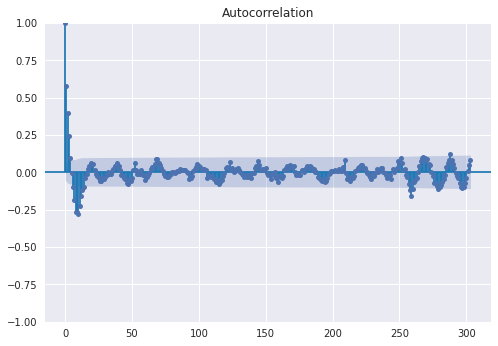

In [344]:
with plt.style.context('seaborn'):
    fig = plot_acf(model.resid, lags=int(len(HW_tr_data)/4))

In [345]:
ljb_df = sm.acorr_ljungbox(model.resid, lags = [1,4,13,52])
md(ljb_df.to_markdown())

|    |   lb_stat |    lb_pvalue |
|---:|----------:|-------------:|
|  1 |   404.045 | 7.25023e-90  |
|  4 |   681.819 | 3.01192e-146 |
| 13 |  1113.86  | 5.97292e-230 |
| 52 |  1207.27  | 1.55791e-218 |

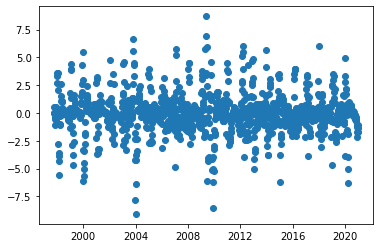

In [346]:
plt.scatter(model.resid.index, model.resid.values)

\normalsize

### Comments{-}

Again this model should be improved for stationarity based on the tests and graphs above. We can see that the residuals do not differ from white-noise significantly. We can also see that the residuals have a pattern/shape. The fit again seems to be leading in a large way as the other graphs. This is most likely due to the data being weekly and accounting for leap years with 53 weeks. All in all, I believe the model is not great for this data. I do believe a better fit may invovle Holt-Winter's exponential smoothing model with an additive trend and multiplicative seasonality. This would also have to take stationarity into account hence something like a differencing method.

\scriptsize